In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

from google.colab import files

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


# 1. Libraries 
<a name = "Libraries"></a>

In [ ]:
#Import Libraries

import pandas as pd  
import numpy as np

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

#Data Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#NLP
from sklearn.feature_extraction.text import CountVectorizer

#WordCloud
from wordcloud import WordCloud, STOPWORDS

#Text Processing
import re
import nltk
nltk.download('popular')

#Language Detection
!pip install langdetect
import langdetect

#Sentiment
from textblob import TextBlob

#ner
import spacy

#Vectorizer
from sklearn import feature_extraction, manifold

#Word Embedding
import gensim.downloader as gensim_api

#Topic Modeling
import gensim

#Model
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import mean_squared_log_error, make_scorer
from keras.optimizers import Adam

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install catboost
from catboost import CatBoostRegressor

#Validation
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

#Location
from geopy.distance import vincenty

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

# 2. Functions 
<a name = 'Functions'></a>

In [ ]:
def predict(model): 
  
  #Make predictions and convert to binary value  
  pred_train = model.predict(X_train) 
  pred_train = np.abs(pred_train)
  
  pred_test = model.predict(X_test)   
  pred_test = np.abs(pred_test)

  #Accuracy
  print('Train RMSLE = {:.3f}'.format(np.sqrt(mean_squared_log_error(y_train,pred_train))))
  print('Test RMSLE = {:.3f}'.format(np.sqrt(mean_squared_log_error(y_test,pred_test))))


def score_func(y_true, y_pred, **kwargs):
  y_true = np.abs(y_true)
  y_pred = np.abs(y_pred)

  return np.sqrt(mean_squared_log_error(y_true, y_pred))

scorer = make_scorer(score_func)

def grid_results(grid):
  print(" Results from Grid Search " )
  print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
  print("\n The best score across ALL searched params:\n", grid.best_score_)
  print("\n The best parameters across ALL searched params:\n", grid.best_params_)

def join_df(train, test, log = False):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [TARGET_COL]]

  if log == True:
    df[num_cols + [TARGET_COL]] = df[num_cols + [TARGET_COL]].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [TARGET_COL]]
  
  return train, test, features

def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = mh_metric(y_val, preds_val)
    print(f'\nMH metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = mh_metric(target, oofs)
  print(f'\n\nMH metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

def mh_metric(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  submission['TARGET(PRICE_IN_LACS)'] = preds_test

  ## 2. Saving our predictions to a csv file
  submission.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  files.download(file_name)

#Download Submission File
def download(model, model_features, file_name = 'hacklive_sub.csv'):

  pred_test = model.predict(test[model_features])
  pred_test = np.expm1(pred_test)

  #Setting the target column with our obtained predictions
  submission[TARGET_COL] = pred_test 

  #Saving our predictions to a csv file
  submission.to_csv(file_name, index = False)
  
  #Downloadingthe csv file
  files.download(file_name)

def preprocess_text(text, flg_stemm=False, flg_lemm=True):

    lst_stopwords = nltk.corpus.stopwords.words("english")
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()    
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

# 3. Load Data 
<a name = "Load_Data"></a>

In [ ]:
#Load Dataset
test = pd.read_csv('/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Data/Test.csv')
train = pd.read_csv('/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Data/Train.csv')
submission = pd.read_csv('/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Data/sample_submission.csv')

#Making Column Headers Lowercase
train.columns = [x.lower() for x in train.columns]
test.columns = [x.lower() for x in test.columns]

#Define Target Column
TARGET_COL = 'target(price_in_lacs)'

#Grouping Columns
num_cols = ['square_ft', 'bhk_no.']
loc_cols = ['latitude', 'longitude']
cat_cols = ['posted_by', 'under_construction', 'rera', 'bhk_or_rk', 'ready_to_move','resale']
text_cols = ['address']

#Combining Train and Test Data
df, features = join_df(train, test)

In [ ]:
train.head()

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,address,longitude,latitude,target(price_in_lacs)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


# 4. EDA and Data Visualization
<a name = '4'></a>

## 4.1 Target Distribution 
<a name = 'Target_Distribution'></a>

### 4.1.1 Skewness 
<a name = 'Skewness'></a>

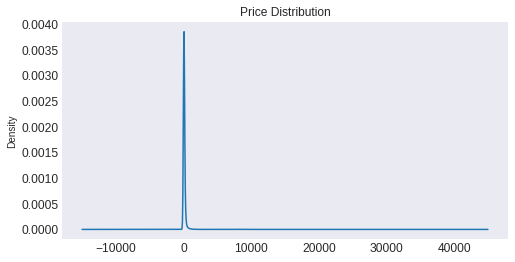

In [ ]:
#Price Distribution
df[TARGET_COL].plot(kind = 'density', title = 'Price Distribution', fontsize=12, figsize=(8, 4))

Above graph shows that our target variable is highgly skewed. To tackle this, we apply Log Transform.

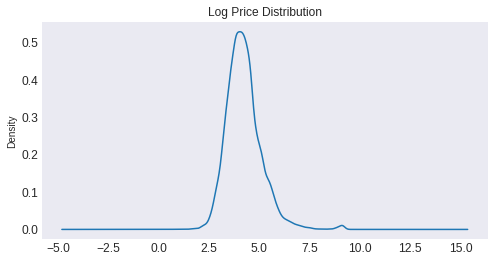

In [ ]:
#Log Price Distribution
pd.Series(np.log1p(df[TARGET_COL])).plot(kind = 'density', title = 'Log Price Distribution', fontsize=12, figsize=(8, 4))

### 4.1.2 Outliers 
<a name = 'Outliers'></a>

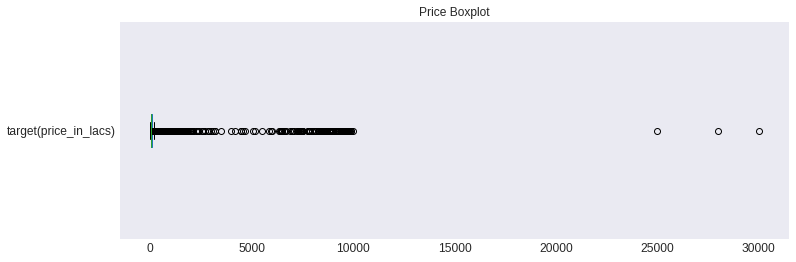

In [ ]:
#Price Boxplot
df[TARGET_COL].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Price Boxplot', fontsize=12)

Thus, there are a lot of outliers in our Target. So we apply Log Transform.

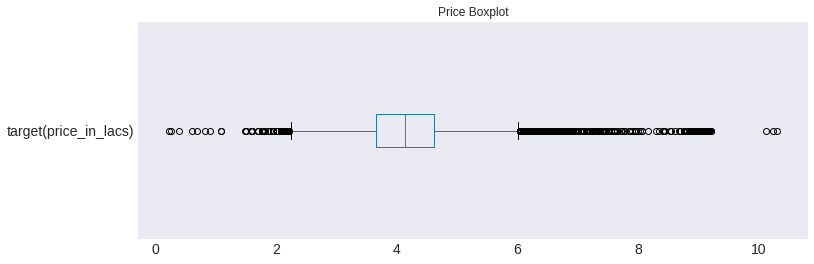

In [ ]:
#Log Price BoxPlot
pd.Series(np.log1p(df[TARGET_COL])).plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Price Boxplot', fontsize=14)

## 4.2 Data Description 
<a name = 'Data_Description'></a>

### 4.2.1 Data Info 
<a name = 'Data_Info'></a> 

In [ ]:
#Chech Data Info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   posted_by              29451 non-null  object 
 1   under_construction     29451 non-null  int64  
 2   rera                   29451 non-null  int64  
 3   bhk_no.                29451 non-null  int64  
 4   bhk_or_rk              29451 non-null  object 
 5   square_ft              29451 non-null  float64
 6   ready_to_move          29451 non-null  int64  
 7   resale                 29451 non-null  int64  
 8   address                29451 non-null  object 
 9   longitude              29451 non-null  float64
 10  latitude               29451 non-null  float64
 11  target(price_in_lacs)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


### 4.2.2 Null Values 
<a name = 'Null_Values'></a>

In [ ]:
#Check null values in Train Set
train.isnull().sum()

posted_by                0
under_construction       0
rera                     0
bhk_no.                  0
bhk_or_rk                0
square_ft                0
ready_to_move            0
resale                   0
address                  0
longitude                0
latitude                 0
target(price_in_lacs)    0
dtype: int64

In [ ]:
#Check null values in Test Set
test.isnull().sum()

posted_by             0
under_construction    0
rera                  0
bhk_no.               0
bhk_or_rk             0
square_ft             0
ready_to_move         0
resale                0
address               0
longitude             0
latitude              0
dtype: int64

Thus, Train and Test Data have no missing values.

### 4.2.3 Unique Values 
<a name = 'Unique_Values'></a>

In [ ]:
train.nunique()

posted_by                    3
under_construction           2
rera                         2
bhk_no.                     16
bhk_or_rk                    2
square_ft                19561
ready_to_move                2
resale                       2
address                   6899
longitude                 4087
latitude                  4078
target(price_in_lacs)     1172
dtype: int64

In [ ]:
test.nunique()

posted_by                 3
under_construction        2
rera                      2
bhk_no.                  17
bhk_or_rk                 2
square_ft             37704
ready_to_move             2
resale                    2
address               11048
longitude              5907
latitude               5914
dtype: int64

We find that the number of unique values for `bhk_no.` is different in Train and Test set. Thus, we cannot apply encoding separately on this feature. We have to apply on combined dataset.

## 4.3 Analyzing Variables and their Relationships <a name = 'Analyzing_Variables_and_their_Relationships'></a>

### 4.3.1 Numerical Variable Analysis <a name = 'Numerical Variable Analysis'></a>

The Numerical Variables in our Data Set are:
- square_ft
- bhk_no.
- longitude
- latitude

#### Univariate Analysis <a name = 'Numerical_Univariate_Analysis'></a>

##### Box Plot <a name = 'Numerical_Box_Plot'></a>

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(8, 9))

for i, c in enumerate(num_cols):
  train[[c]].boxplot(ax=axes[i], vert=False)

The Box Plot reveals too many outliers in the Numerical Variables.

##### Density Plot <a name = 'Numerical_Density_Plot'></a>

In [ ]:
sns.set(font_scale=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

The data is skewed more in 'square_ft' and 'latitude'.

##### Bivariate Analysis <a name = 'Numerical_Bivariate_Analysis'></a>

##### Correlation Heatmap <a name = 'Numerical_Correlation_Heatmap'></a>

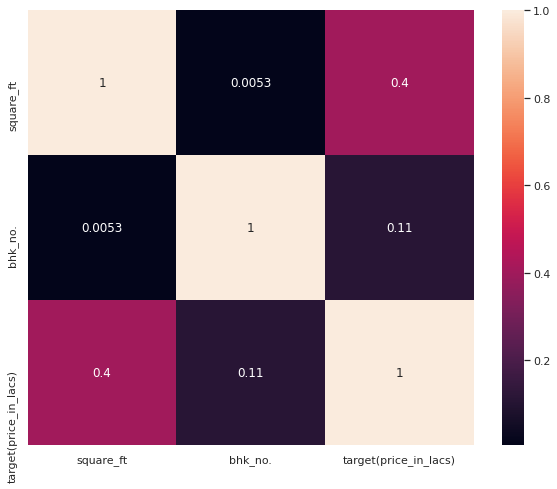

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(train[num_cols + [TARGET_COL]].corr(), annot=True)

##### Pair Plot <a name = 'Numerical_Pair_Plot'></a>

In [ ]:
n = ['square_ft']

In [ ]:
sns.pairplot(train[n + [TARGET_COL]], height=5, aspect=24/16)

### 4.3.2 Categorical Variable Analysis <a name = '4.3.2'></a>

The Categorical Variables in our dataset are:
- posted_by
- under_construction
- rera
- bhk_or_rk
- ready_to_move
- resale


#### Univariate Analysis 
<a name = 'Categorical_Univariate_Analysis'></a>

##### Pie Chart 
<a name = 'Categorical_Pie_Chart'></a>

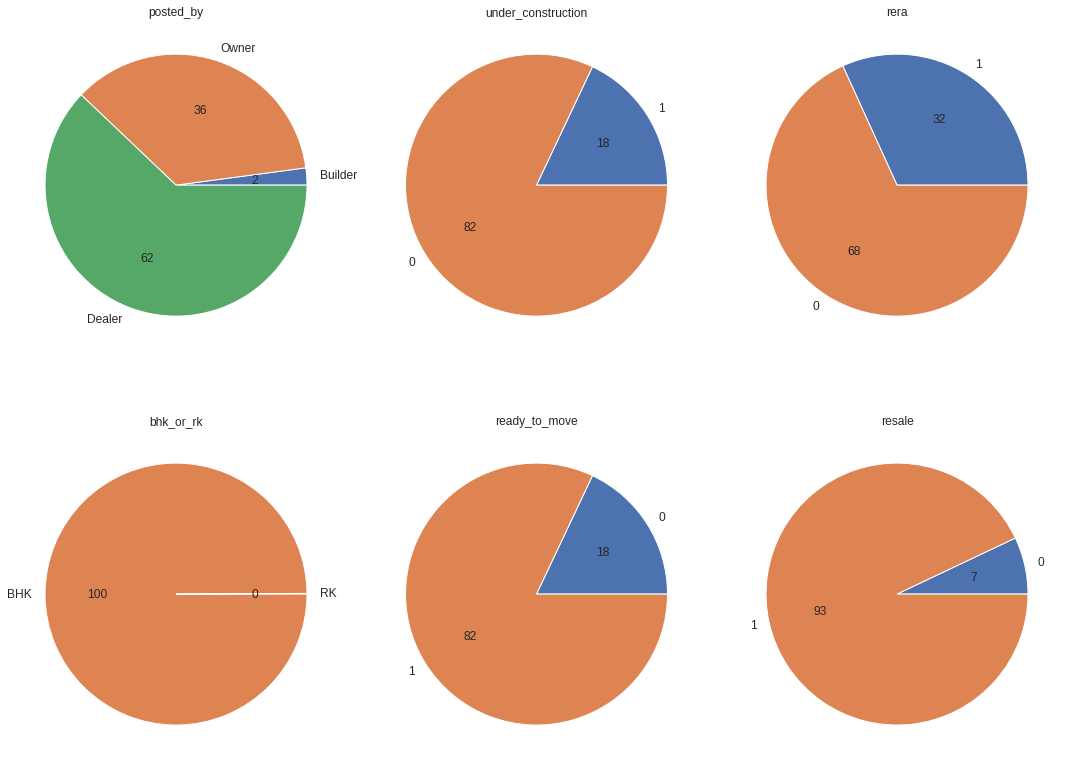

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

# unpack all the axes subplots
axe = [sub for x in axes for sub in x]

for i, (c, ax) in enumerate(zip(cat_cols, axes.flatten())):
  
  train[c].value_counts()[::-1].plot(kind = 'pie', ax=axe[i], title=c, autopct='%.0f', fontsize=12)
  axe[i].set_ylabel('')
    
plt.tight_layout()

##### Cat Plot <a name = 'Categorical_Cat_Plot'></a>

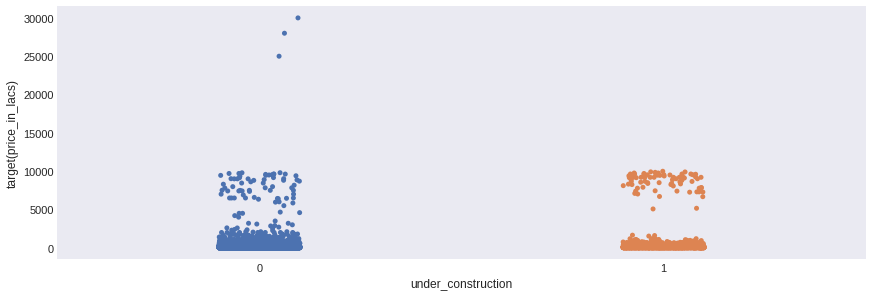

In [ ]:
#Price Distribution with under_construction

sns.catplot(x="under_construction", y=TARGET_COL, data=train, height=4, aspect=24/8)

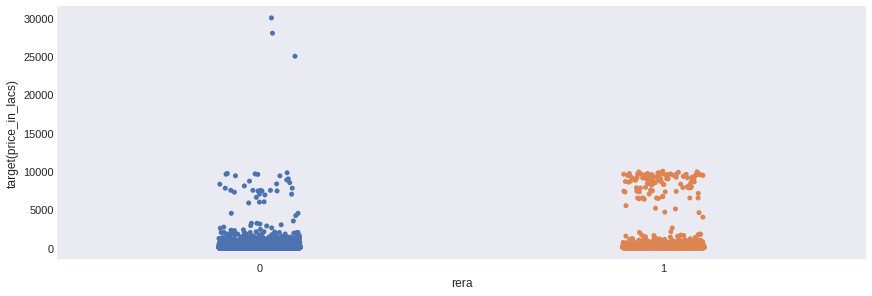

In [ ]:
#Price Distribution with RERA

sns.catplot(x="rera", y=TARGET_COL, data=train, height=4, aspect=24/8)

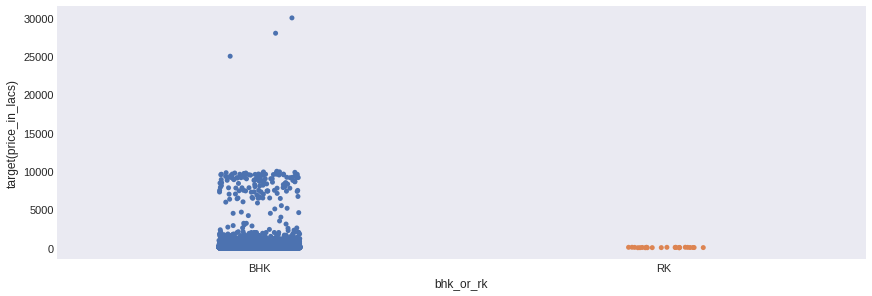

In [ ]:
#Price Distribution with bhk_or_rk

sns.catplot(x="bhk_or_rk", y=TARGET_COL, data=train, height=4, aspect=24/8)

This shows that price of RK is very low as compared to BHK.

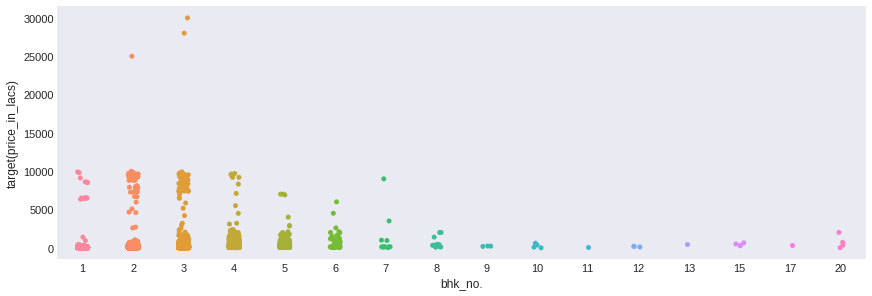

In [ ]:
#Price Distribution with bhk_no.

sns.catplot(x="bhk_no.", y=TARGET_COL, data=train, height=4, aspect=24/8)

This is strange, that more rooms mean lesser price.

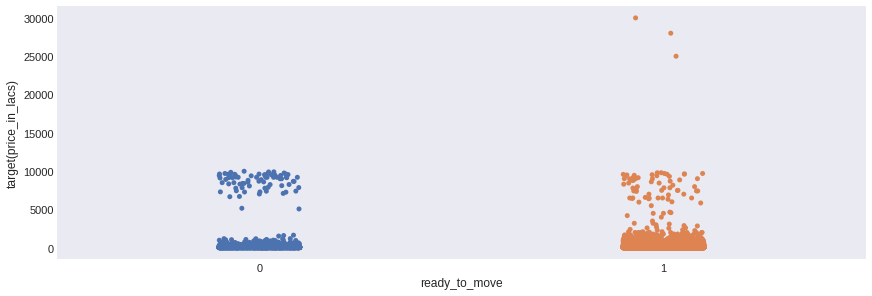

In [ ]:
#Price Distribution with ready_to_move

sns.catplot(x="ready_to_move", y=TARGET_COL, data=train, height=4, aspect=24/8)

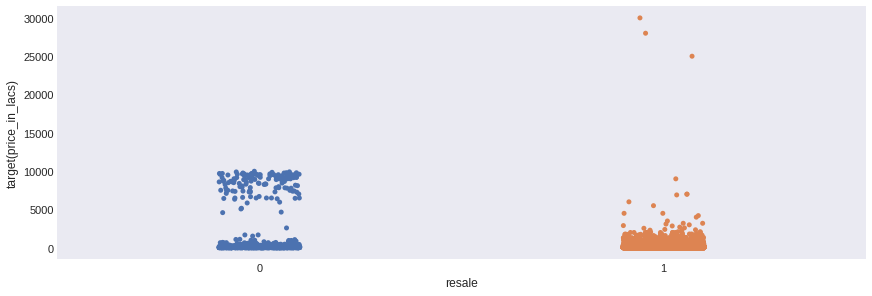

In [ ]:
#Price Distribution with resale

sns.catplot(x="resale", y=TARGET_COL, data=train, height=4, aspect=24/8)

The price of Resale Houses is lower as compared to new houses.

### 4.3.3 Text Variable Analysis <a name = '433'><a/>

#### Word Cloud <a name = 'Word_Cloud'></a>

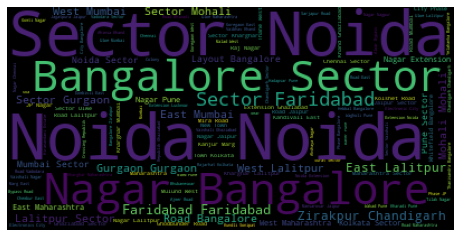

In [ ]:
wc = WordCloud(stopwords = set(list(STOPWORDS) + ['|']), random_state = 42).generate(' '.join(train['address']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.show()  

# 5. Data Preprocessing
<a name = '5'></a>

## 5.1 Log Transform
<a name = '51'></a>

In [ ]:
df[num_cols + [TARGET_COL]] = df[num_cols + [TARGET_COL]].apply(lambda x: np.log1p(x))

## 5.2 One Hot Encoding
<a name = '52'></a>

In [ ]:
df = pd.get_dummies(df, columns = cat_cols)

## 5.3 Label Encoding
<a name = '53'></a>

In [ ]:
#Encode Categorical Variables
# df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform) 

In [ ]:
df.head(1)

## 5.4 Obtain Processed Data Sets
<a name = '54'></a>

In [ ]:
trainPro, testPro, features = split_df_and_get_features(df, train.shape[0])

In [ ]:
#Define Encoded Categorical and Numerical Columns
cat_num_cols = [c for c in features if c not in ['address']]

#CatBoostClassifier

In [ ]:
!pip install catboost

In [ ]:
#New CatBoostClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# from catboost import CatBoostRegressor
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


#Load Dataset
test = pd.read_csv('/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Data/Test.csv')
train = pd.read_csv('/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Data/Train.csv')

#Making Column Headers Lowercase
train.columns = [x.lower() for x in train.columns]
test.columns = [x.lower() for x in test.columns]

#Obtaining Categorical Columns
cat_columns = ['posted_by', 'under_construction', 'rera', 'bhk_no.', 'bhk_or_rk', 'ready_to_move','resale']


#Label Encoding
df_encoding = {"posted_by":     {"Dealer": 1,
                                 "Owner": 2, 
                                 "Builder":3},
               
                "bhk_or_rk": {"RK": 1,
                              "BHK": 2},
                }

#To convert the columns to numbers using replace :
train.replace(df_encoding, inplace = True)
test.replace(df_encoding, inplace = True)

#Convert float to int for model
train[cat_columns] = train[cat_columns].astype(int)
test[cat_columns] = test[cat_columns].astype(int)

#Define Features and Label
features = ['posted_by', 'under_construction', 'rera', 'bhk_no.', 'bhk_or_rk',
            'square_ft', 'ready_to_move', 'resale', 'longitude',
            'latitude'] 

X=train[features]
y=train['target(price_in_lacs)']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 23, shuffle = True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
for i in range(100,1000, 100):

  model = CatBoostRegressor(task_type= 'GPU',
                            depth = 6,
                             l2_leaf_reg = 4, #0.68 
                            random_seed = 23,
                            n_estimators = i)  

  model.fit(X_train, y_train, 
              cat_features= cat_columns , 
              plot=True,
              eval_set=(X_test, y_test),
              early_stopping_rounds = 30,
              verbose = 0,
            )  

  #Make predictions
  print(i)
  predict(model)

In [ ]:
#Grid Search
model = CatBoostRegressor(task_type = 'GPU' )

parameters = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1],
          'border_count':[32],
          }


grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1, scoring = scorer )

grid.fit(X_train, y_train,
         cat_features= cat_columns , 
          )

grid_results(grid)

In [ ]:
#Random Search

model = CatBoostRegressor(task_type = 'GPU' )

parameters = {'depth': np.arange(1,11),
          # 'iterations':[250,100,500,1000],
          # 'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':np.arange(1,11)
          # 'border_count':[32],
          }

grid = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_jobs=-1, n_iter = 2 ,scoring = scorer )

grid.fit(X_train, y_train,
         cat_features= cat_columns , 
          verbose = 1)

# grid_results(grid)

#LGBM Regressor

In [ ]:
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
train.head()

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,address,longitude,latitude,target(price_in_lacs)
0,2,0,0,2,2,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,1,0,0,2,2,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,2,0,0,2,2,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,2,0,1,2,2,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,1,1,0,2,2,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [ ]:
#Define Features and Label
features = ['posted_by', 'under_construction', 'rera', 'bhk_no.', 'bhk_or_rk',
            'square_ft', 'ready_to_move', 'resale', 'longitude',
            'latitude'] 

X=train[features]
y=train['target(price_in_lacs)']

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 23, shuffle = True)

In [ ]:
# lightgbm = LGBMRegressor(objective='regression', 
#                                        num_leaves=4,
#                                        learning_rate=0.01, 
#                                        n_estimators=1000,
#                                        max_bin=200, 
#                                        bagging_fraction=0.75,
#                                        bagging_freq=5, 
#                                        bagging_seed=7,
#                                        feature_fraction=0.2,
#                                        feature_fraction_seed=7,
#                                        verbose=-1,
#                                        )

lightgbm = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,    
                        colsample_bytree = 0.65,
                        metric = 'None',
                        num_leaves = 50, 
                       
                       )
lightgbm.fit(X_train, y_train)

predict(lightgbm)

Train RMSLE = 0.410
Test RMSLE = 0.595


## XGBoost

In [ ]:
#XGBoost Original

xgboost = XGBRegressor(  
                        learning_rate=0.01,
                        n_estimators=3460,
                        max_depth=7, 
                        min_child_weight=0,
                        gamma=1, 
                        subsample=0.7,
                        colsample_bytree=0.7,
                        objective='reg:linear', 
                        nthread=-1,
                        scale_pos_weight=1, 
                        seed=27,
                        reg_alpha=0.00006,
                        )  

xgboost.fit(X_train, y_train)
predict(xgboost)

[15:48:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE = 0.333
Test RMSLE = 0.409


In [ ]:
#XGBoost Trial

xgboost = XGBRegressor(  
                        learning_rate=0.01,
                        n_estimators=3460,
                        max_depth=8, 
                        min_child_weight=0,
                        gamma=1, 
                        subsample=0.8,
                        colsample_bytree=0.7,
                        objective='reg:linear', 
                        nthread=-1,
                        scale_pos_weight=1, 
                        seed=27,
                        reg_alpha=0.00006,
                        )  

xgboost.fit(X_train, y_train)
predict(xgboost)

[16:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSLE = 0.291
Test RMSLE = 0.402


In [ ]:
submission_test_X = xgboost.predict(test[features])
submission_test_X = np.abs(submission_test_X)

#Generating Submission File
submission['TARGET(PRICE_IN_LACS)'] = submission_test_X

# submission_file = pd.DataFrame({'TARGET(PRICE_IN_LACS)': submission_test_X.flatten()})
submission.to_csv("my_submission6.csv", index = False)

!mv my_submission6.csv '/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files'

files.download('/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files/my_submission6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
parameters = {'learning_rate': [0.03,0.001,0.01,0.1,0.2,0.3],
          'n_estimators':np.arange(100, 1000, 100),
          # 'l2_leaf_reg':np.arange(1,11)
          # 'border_count':[32],
          }

grid = RandomizedSearchCV(estimator=xgboost, param_distributions = parameters, cv = 5, n_jobs=-1, n_iter = 2 ,scoring = 'mean_squared_log_error' )

grid.fit(X_train, y_train,
         verbose = 100)

grid_results(grid)

In [ ]:
X_train.head()

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,longitude,latitude
4899,2,0,0,3,2,1562.500000,1,1,9.878060,76.303890
11824,1,1,0,2,2,780.000000,0,1,22.541110,88.337780
15420,1,1,1,1,2,353.028614,0,0,24.862517,78.282467
23006,1,0,1,3,2,1014.507457,1,1,20.742166,80.104602
22218,1,0,1,2,2,1017.408998,1,1,19.175900,72.952200


# 6. New Models
<a name = '6'></a>

In [ ]:
train.head()        

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,address,longitude,latitude,target(price_in_lacs)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


## LightGBM

In [ ]:
lgb = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,    
                        colsample_bytree = 0.65,
                        metric = 'None',
                        # num_leaves = 50, 
                        random_state = 42
                       )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(lgb, fit_params, trainPro, testPro, cat_num_cols)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 's11_lgbm_oneHot.csv')    

In [ ]:
!mv s11_lgbm_oneHot.csv '/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files'

## XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=42,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(xgb, fit_params, trainPro, testPro, cat_num_cols)

In [ ]:
xgb_preds_t = np.expm1(xgb_preds)
download_preds(xgb_preds_t, file_name = 's12_xgb.csv')    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!mv s12_xgb.csv '/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files'

# Ensemble

In [ ]:
train_new = train[[TARGET_COL]]
train_new[TARGET_COL] = np.log1p(train_new[TARGET_COL])

test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

# train_new['cb'] = cb_oofs
# test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [TARGET_COL]]

In [ ]:
lgb = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,    
                        colsample_bytree = 0.65,
                        metric = 'None',
                        # num_leaves = 50, 
                        random_state = 42
                       )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(lgb, fit_params, train_new, test_new, cat_num_cols)

# 7. Feature Engineering
<a name = '7'></a>

In [ ]:
train.head()

In [ ]:
df, features = join_df(train, test, log = True)

In [ ]:
#Label Encoding
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform) 

# OneHot Encoding
# df = pd.get_dummies(df, columns = cat_cols)

In [ ]:
df.head()

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,address,longitude,latitude,target(price_in_lacs)
0,2,0,0,1.098612,0,7.171070,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,4.025352
1,1,0,0,1.098612,0,7.151485,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,3.951244
2,2,0,0,1.098612,0,6.839647,1,1,"Jigani,Bangalore",12.778033,77.632191,3.784190
3,2,0,1,1.098612,0,6.836175,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,4.151040
4,1,1,0,1.098612,0,6.907765,0,1,"New Town,Kolkata",22.592200,88.484911,4.119037


## 7.1 Statistical Features based on Cities
<a name = '71'></a>

In [ ]:
#Obtain Cities
df['city'] = df['address'].str.rsplit(',').str[-1] 

In [ ]:
#Obtain Statistical Features

df['city_mean_square_ft'] = df.groupby('city')['square_ft'].transform('mean')
df['city_max_square_ft'] = df.groupby('city')['square_ft'].transform('max')
df['city_min_square_ft'] = df.groupby('city')['square_ft'].transform('min')

df['city_mean_bhk_no.'] = df.groupby('city')['bhk_no.'].transform('mean')
df['city_max_bhk_no.'] = df.groupby('city')['bhk_no.'].transform('max')
df['city_min_bhk_no.'] = df.groupby('city')['bhk_no.'].transform('min')

In [ ]:
df.city.value_counts()  

## 7.2 Bag of Words on Address Column
<a name = '72'></a>

In [ ]:
#Top Words Occuring in Address

TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['address']).toarray()

c = 'address'
txt_fts_names = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names] = txt_to_fts

In [ ]:
df.head()

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,address,longitude,latitude,target(price_in_lacs),city,city_mean_square_ft,city_max_square_ft,city_min_square_ft,city_mean_bhk_no.,city_max_bhk_no.,city_min_bhk_no.,address_word_0_count,address_word_1_count,address_word_2_count,address_word_3_count,address_word_4_count,address_word_5_count,address_word_6_count,address_word_7_count,address_word_8_count,address_word_9_count,address_word_10_count,address_word_11_count,address_word_12_count,address_word_13_count,address_word_14_count,address_word_15_count,address_word_16_count,address_word_17_count,address_word_18_count,address_word_19_count,address_word_20_count,address_word_21_count,address_word_22_count,address_word_23_count,address_word_24_count,address_word_25_count,address_word_26_count,address_word_27_count,address_word_28_count,address_word_29_count,address_word_30_count,address_word_31_count,address_word_32_count,address_word_33_count,address_word_34_count,address_word_35_count,address_word_36_count,address_word_37_count,address_word_38_count,address_word_39_count,address_word_40_count,address_word_41_count,address_word_42_count,address_word_43_count,address_word_44_count,address_word_45_count,address_word_46_count,address_word_47_count,address_word_48_count,address_word_49_count
0,2,0,0,1.098612,0,7.171070,1,1,"Ksfc Layout,Bangalore",2.636906,4.364346,4.025352,Bangalore,7.265768,19.354990,3.433988,1.253933,3.044522,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1.098612,0,7.151485,1,1,"Vishweshwara Nagar,Mysore",2.585848,4.352142,3.951244,Mysore,7.171865,8.289390,4.110880,1.223913,1.791759,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1.098612,0,6.839647,1,1,"Jigani,Bangalore",2.623076,4.364781,3.784190,Bangalore,7.265768,19.354990,3.433988,1.253933,3.044522,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,1,1.098612,0,6.836175,1,1,"Sector-1 Vaishali,Ghaziabad",3.389202,4.361116,4.151040,Ghaziabad,7.062903,9.464021,3.496508,1.203225,1.791759,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,1,0,1.098612,0,6.907765,0,1,"New Town,Kolkata",3.160916,4.494070,4.119037,Kolkata,7.047386,12.119422,4.700489,1.255454,2.772589,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## 7.3 Additional Statistical Features and Length Analysis
<a name = '73'></a>

In [ ]:
#Area Per Room
df['area_per_room'] = df['square_ft']/df['bhk_no.']

#Number of Houses in City
df['houses_per_city'] = df['city'].map(df['city'].value_counts())

#Length of Address
df['address_len'] = df['address'].apply(lambda x: len(x))

#Clean Address
df["clean_address"] = df["address"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, ))

#Word Count
df['clean_address_word_count'] = df["clean_address"].apply(lambda x: len(str(x).split(" ")))

#Character Count
df['clean_address_char_count'] = df["clean_address"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#Sentence Count    
df['clean_address_sentence_count'] = df["clean_address"].apply(lambda x: len(str(x).split(".")))

#Average Word Length
df['clean_address_avg_word_length'] = df['clean_address_char_count'] / df['clean_address_word_count']

#Average Sentence Length
df['clean_address_avg_sentence_length'] = df['clean_address_word_count'] / df['clean_address_sentence_count']

## 7.4 Geospatial Analysis
<a name = '74'></a>

In [ ]:
# city_coords = {}

# for dat in city_lat_long.iterrows():
#     row = dat[1]
#     if row['Name'] not in city_pop_data['City'].values:   
#         continue           
#     else: 
#         city_coords[row['Name']] = (float(row['Latitude']), float(row['Longitude']))

### 7.4.1 Rotational Latitude and Longitudes
<a name = '741'></a>

In [ ]:
df.dropna(inplace = True, subset = ['latitude', 'longitude'])

On close inspection of the data it is found that the values of latitude and longitude are interchanged in both train as well as test set. So we intercgange the values.

Ideal Value Range:  
Latitude  = [-90, 90]  
Longitude = [-180, 180]

In [ ]:
#Values of Latitude and Longitude before Interchange
print(f"Latitude Range before Interchange =  {df.latitude.min(), df.latitude.max()}")
print(f"Longitude Range before Interchange = {df.longitude.min(), df.longitude.max()}")

Latitude Range before Interchange =  (-121.7612481, 175.27804)
Longitude Range before Interchange = (-38.391261, 65.18333)


In [ ]:
#Interchange Latitude and Longitude Values
df.rename(columns={'latitude':'longitude', 'longitude': 'latitude'}, inplace=True)

#Values of Latitude and Longitude after Interchange
print(f"Latitude Range after Interchange =  {df.latitude.min(), df.latitude.max()}")
print(f"Longitude Range after Interchange = {df.longitude.min(), df.longitude.max()}")

Latitude Range after Interchange =  (-38.391261, 65.18333)
Longitude Range after Interchange = (-121.7612481, 175.27804)


In [ ]:
df['longitude_15'] = df['longitude']*np.cos(15* np.pi / 180) - df['latitude']*np.sin(15* np.pi/180)
df['longitude_30'] = df['longitude']*np.cos(30* np.pi / 180) - df['latitude']*np.sin(30* np.pi/180)
df['longitude_45'] = df['longitude']*np.cos(45* np.pi / 180) - df['latitude']*np.sin(45* np.pi/180)
df['longitude_60'] = df['longitude']*np.cos(60* np.pi / 180) - df['latitude']*np.sin(60* np.pi/180)
df['longitude_75'] = df['longitude']*np.cos(75* np.pi / 180) - df['latitude']*np.sin(75* np.pi/180)

df['latitude_15'] = df['longitude']*np.sin(15* np.pi / 180) + df['latitude']*np.cos(15* np.pi/180)
df['latitude_30'] = df['longitude']*np.sin(30* np.pi / 180) + df['latitude']*np.cos(30* np.pi/180)
df['latitude_45'] = df['longitude']*np.sin(45* np.pi / 180) + df['latitude']*np.cos(45* np.pi/180)
df['latitude_60'] = df['longitude']*np.sin(60* np.pi / 180) + df['latitude']*np.cos(60* np.pi/180)
df['latitude_75'] = df['longitude']*np.sin(75* np.pi / 180) + df['latitude']*np.cos(75* np.pi/180)

### 7.4.2 Distance from Capital City 
<a name = '742'></a>

In [ ]:
#Preparing DataFrame for Capital City

capital_df = {'capital_city':['Srinagar', 'Jammu', 'Shimla','Chandigarh', 'Dehradun', 'New Delhi', 'Lucknow', 'Patna', 'Ranchi', 'Kolkata', 'Bhubhaneshwar', 'Itanagar', 'Gangtok', 'Kohima', 'Dispur', 'Shillong', 'Imphal', 'Agartala', 'Aizawl', 'Bhopal', 'Raipur', 'Jaipur', 'Gandhinagar', 'Daman', 'Silvassa', 'Mumbai', 'Hyderabad', 'Panaji', 'Bangalore', 'Channai', 'Pondicherry', 'Port Blair', 'Trivandrum', 'Kavaratti'], 
              'capital_longitude':[74.8,74.8,77.2,76.9,78.0,77.1,80.9,85.1,85.3,88.4,85.8,93.6,88.6,94.2,91.8,91.9,93.9,91.2,92.7,77.4,81.7,75.8,72.7,72.8,73.0,72.8,78.6,73.5,77.6,80.2,79.8,92.7,77.0,72.6],
              'capital_latitude':[34.0,32.7,31.1,30.7,30.3,28.5,26.8,25.6,23.3,22.6,20.2,27.1,27.3,25.6,26.1,25.6,24.7,23.9,23.7,23.3,21.2,26.8,23.2,20.4,20.3,18.9,17.5,15.3,12.9,13.0,11.9,11.6,8.5,10.6],
              'population(in_millions)':[1.2,1.7,0.7,0.9,1.3,13.8,3.7,4.7,2.8,4.6,0.66,0.035,0.2,0.3,0.8,0.27,0.8,1.5,0.3,1.8,3.0,5.2,1.3,0.1,0.2,11.9,3.8,0.8,4.3,4.2,0.97,0.3,3.2,0.06],
              'elevation(MSL)':[1666,367,2202,347,695,233,128,60,647,6,46,524,1756,1406,54,1598,774,16,1026,523,325,390,61,12,32,11,545,52,921,16,6,1,7,4]}

capital_df = pd.DataFrame(capital_df)

In [ ]:
capital_df.head()

In [ ]:
df.head()

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,address,latitude,longitude,target(price_in_lacs),city,city_mean_square_ft,city_max_square_ft,city_min_square_ft,city_mean_bhk_no.,city_max_bhk_no.,city_min_bhk_no.,address_word_0_count,address_word_1_count,address_word_2_count,address_word_3_count,address_word_4_count,address_word_5_count,address_word_6_count,address_word_7_count,address_word_8_count,address_word_9_count,address_word_10_count,address_word_11_count,address_word_12_count,address_word_13_count,address_word_14_count,address_word_15_count,address_word_16_count,address_word_17_count,address_word_18_count,address_word_19_count,address_word_20_count,...,latitude_45,latitude_60,latitude_75,close_city,close_city_distance,close_city_population,close_city_elevation,close_city_name_Agartala,close_city_name_Bangalore,close_city_name_Bhopal,close_city_name_Bhubhaneshwar,close_city_name_Chandigarh,close_city_name_Channai,close_city_name_Daman,close_city_name_Dehradun,close_city_name_Dispur,close_city_name_Gandhinagar,close_city_name_Gangtok,close_city_name_Hyderabad,close_city_name_Imphal,close_city_name_Itanagar,close_city_name_Jaipur,close_city_name_Jammu,close_city_name_Kavaratti,close_city_name_Kohima,close_city_name_Kolkata,close_city_name_Lucknow,close_city_name_Mumbai,close_city_name_New Delhi,close_city_name_Panaji,close_city_name_Patna,close_city_name_Pondicherry,close_city_name_Port Blair,close_city_name_Raipur,close_city_name_Ranchi,close_city_name_Shillong,close_city_name_Shimla,close_city_name_Silvassa,close_city_name_Srinagar,close_city_name_Trivandrum
0,2,0,0,1.098612,0,7.171070,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,4.025352,Bangalore,7.265768,19.354990,3.433988,1.253933,3.044522,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64.041155,73.686760,78.310733,"(Bangalore, 7.7373060424043, 4.3, 921)",7.737306,4.3,921,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1.098612,0,7.151485,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,3.951244,Mysore,7.171865,8.289390,4.110880,1.223913,1.791759,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,62.875329,72.513444,77.209888,"(Bangalore, 124.75963255860677, 4.3, 921)",124.759633,4.3,921,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1.098612,0,6.839647,1,1,"Jigani,Bangalore",12.778033,77.632191,3.784190,Bangalore,7.265768,19.354990,3.433988,1.253933,3.044522,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,63.929682,73.620466,78.294137,"(Bangalore, 13.938261435978871, 4.3, 921)",13.938261,4.3,921,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,1,1.098612,0,6.836175,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,4.151040,Ghaziabad,7.062903,9.464021,3.496508,1.203225,1.791759,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,74.943985,81.303452,82.122223,"(New Delhi, 28.65237607952523, 13.8, 233)",28.652376,13.8,233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1.098612,0,6.907765,0,1,"New Town,Kolkata",22.592200,88.484911,4.119037,Kolkata,7.047386,12.119422,4.700489,1.255454,2.772589,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,78.543378,87.926281,91.317152,"(Kolkata, 8.773597826766782, 4.6, 6)",8.773598,4.6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Function to obtin closest Capital City from given location
def closest_point(location, capital_df = capital_df):
    closest_location = None

    for _, row in capital_df.iterrows(): 
        distance = vincenty(location, (row['capital_latitude'], row['capital_longitude'])).kilometers
        if closest_location is None:
            closest_location = (row['capital_city'], distance, row['population(in_millions)'], row['elevation(MSL)'], row['capital_latitude'], row['capital_longitude'])
        elif distance < closest_location[1]:
            closest_location = (row['capital_city'], distance, row['population(in_millions)'], row['elevation(MSL)'], row['capital_latitude'], row['capital_longitude'])
    return closest_location

In [ ]:
df['close_city'] = df.apply(lambda x: closest_point((x['latitude'],x['longitude']),capital_df), axis = 1)
df['close_city_name'] = [x[0] for x in df['close_city'].values]
df['close_city_distance'] = [x[1] for x in df['close_city'].values]
df['close_city_population'] = [x[2] for x in df['close_city'].values]
df['close_city_elevation'] = [x[3] for x in df['close_city'].values]
df['close_city_latitude'] = [x[4] for x in df['close_city'].values]
df['close_city_longitude'] = [x[4] for x in df['close_city'].values]  

In [ ]:
df = pd.get_dummies(df, columns = ['close_city_name'])

### 7.4.3 Haversine Distance
<a name = '743'></a>

In [ ]:
def haversine_dist(lat1,lng1,lat2,lng2):
  lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
  radius = 6371  # Earth's radius taken from google
  lat = lat2 - lat1
  lng = lng2 - lng1
  d = np.sin(lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2) ** 2
  h = 2 * radius * np.arcsin(np.sqrt(d))
  return h

# def haversine_calculation(location, capital_df = capital_df):
#       closest_location = None
#       lat1, lng1 = location
      
#       for _, row in capital_df.iterrows(): 
#         distance = haversine_dist(lat1, lng1, lat2 = row['capital_latitude'], lng2 = row['capital_longitude'])
#         if closest_location is None:
#             closest_location = distance
#         elif distance < closest_location:
#             closest_location = distance
#       return closest_location

In [ ]:
# df['haversineDist'] = df.apply(lambda x: haversine_calculation((x['latitude'],x['longitude']),capital_df), axis = 1)

df['haversineDist'] = df.apply(lambda x: haversine_dist(lat1 = x['latitude'], lng1 = x['longitude'], lat2 = x['close_city_latitude'], lng2 = x['close_city_longitude']), axis = 1)

In [ ]:
df['haversineDist']

### 7.4.5 Manhattan Distance
<a name = '745'></a>

In [ ]:
def manhattan_dist(lat1, lng1, lat2, lng2):
    '''
    calculating two haversine distances by,
     - avoiding Latitude of one point 
     - avoiding Longitude of one point
    and adding it together.
    '''
    a = haversine_dist(lat1, lng1, lat1, lng2)
    b = haversine_dist(lat1, lng1, lat2, lng1)
    return a + b

In [ ]:
df['manhattanDist'] = df.apply(lambda x: manhattan_dist(lat1 = x['latitude'], lng1 = x['longitude'], lat2 = x['close_city_latitude'], lng2 = x['close_city_longitude']), axis = 1)

In [ ]:
df['manhattanDist']

0        6997.000925
1        6977.301529
2        7012.428229
3        4747.416611
4        6702.994376
            ...     
98166    5684.349303
98167    4376.332075
98168    5690.059620
98169    5824.579616
98170    5673.009604
Name: manhattanDist, Length: 98171, dtype: float64

### 7.4.6 Bearing Degree
<a name = '746'></a>

In [ ]:
def bearing_degree(lat1, lng1, lat2, lng2):
    '''
    calculate angle between two points
    '''
    radius = 6371  # Mean radius of Earth
    diff_lng = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(diff_lng) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(diff_lng)
    return np.degrees(np.arctan2(y, x))

In [ ]:
df['bearingDegree'] = df.apply(lambda x: bearing_degree(lat1 = x['latitude'], lng1 = x['longitude'], lat2 = x['close_city_latitude'], lng2 = x['close_city_longitude']), axis = 1)

In [ ]:
df['bearingDegree']

0       -81.987195
1       -81.767908
2       -81.884727
3       -77.925866
4       -76.012513
           ...    
98166   -80.840069
98167   -77.712674
98168   -80.868702
98169   -80.108509
98170   -80.810145
Name: bearingDegree, Length: 98171, dtype: float64

### 7.4.7 Rotation with PCA
<a name = '747'></a>

In [ ]:
from sklearn.decomposition import PCA
def pca(data):
  '''
  input: dataframe containing Latitude and Longitude
  '''
  coordinates = data[['latitude','longitude']].values
  pca_obj = PCA().fit(coordinates)
  pca_latitude = pca_obj.transform(data[['latitude', 'longitude']])[:,0]
  pca_longitude = pca_obj.transform(data[['latitude', 'longitude']])[:,1]
  return pca_latitude, pca_longitude

In [ ]:
df['latitudePCA'], df['longitudePCA'] = pca(df)

## 7. Obtain Processed Data

In [ ]:
df.head(3)

,posted_by,under_construction,rera,bhk_no.,bhk_or_rk,square_ft,ready_to_move,resale,address,latitude,longitude,target(price_in_lacs),city,city_mean_square_ft,city_max_square_ft,city_min_square_ft,city_mean_bhk_no.,city_max_bhk_no.,city_min_bhk_no.,address_word_0_count,address_word_1_count,address_word_2_count,address_word_3_count,address_word_4_count,address_word_5_count,address_word_6_count,address_word_7_count,address_word_8_count,address_word_9_count,address_word_10_count,address_word_11_count,address_word_12_count,address_word_13_count,address_word_14_count,address_word_15_count,address_word_16_count,address_word_17_count,address_word_18_count,address_word_19_count,address_word_20_count,...,close_city_longitude,close_city_name_Agartala,close_city_name_Aizawl,close_city_name_Bangalore,close_city_name_Bhopal,close_city_name_Bhubhaneshwar,close_city_name_Chandigarh,close_city_name_Channai,close_city_name_Daman,close_city_name_Dehradun,close_city_name_Dispur,close_city_name_Gandhinagar,close_city_name_Gangtok,close_city_name_Hyderabad,close_city_name_Imphal,close_city_name_Itanagar,close_city_name_Jaipur,close_city_name_Jammu,close_city_name_Kavaratti,close_city_name_Kohima,close_city_name_Kolkata,close_city_name_Lucknow,close_city_name_Mumbai,close_city_name_New Delhi,close_city_name_Panaji,close_city_name_Patna,close_city_name_Pondicherry,close_city_name_Port Blair,close_city_name_Raipur,close_city_name_Ranchi,close_city_name_Shillong,close_city_name_Shimla,close_city_name_Silvassa,close_city_name_Srinagar,close_city_name_Trivandrum,haversineDist,manhattanDist,bearingDegree,latitudePCA,longitudePCA
0,2,0,0,1.098612,0,7.171070,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,4.025352,Bangalore,7.265768,19.35499,3.433988,1.253933,3.044522,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12.9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6990.323720,6997.000925,-81.987195,-1.826053,8.149367
1,1,0,0,1.098612,0,7.151485,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,3.951244,Mysore,7.171865,8.28939,4.110880,1.223913,1.791759,0.693147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12.9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6898.836920,6977.301529,-81.767908,-0.975899,8.967699
2,2,0,0,1.098612,0,6.839647,1,1,"Jigani,Bangalore",12.778033,77.632191,3.784190,Bangalore,7.265768,19.35499,3.433988,1.253933,3.044522,0.693147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12.9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6996.990647,7012.428229,-81.884727,-1.886009,8.334822


In [ ]:
#Obtain Processed Data Sets

trainPro, testPro, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['address', 'city', 'clean_address', 'close_city', 'close_city_name']]

In [ ]:
df.columns

## 7. Apply Feature Engineered Data to Model


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.297277
[600]	valid_0's rmse: 0.286958
[900]	valid_0's rmse: 0.28276
[1200]	valid_0's rmse: 0.281177
[1500]	valid_0's rmse: 0.280628
[1800]	valid_0's rmse: 0.280322
Early stopping, best iteration is:
[1809]	valid_0's rmse: 0.28026

MH metric score for validation set is 0.2802595864370378

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.307047
[600]	valid_0's rmse: 0.296654
[900]	valid_0's rmse: 0.292038
[1200]	valid_0's rmse: 0.290582
[1500]	valid_0's rmse: 0.289586
[1800]	valid_0's rmse: 0.288752
[2100]	valid_0's rmse: 0.288772
Early stopping, best iteration is:
[1947]	valid_0's rmse: 0.288647

MH metric score for validation set is 0.2886473169472021

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.30637
[600]	valid_0's

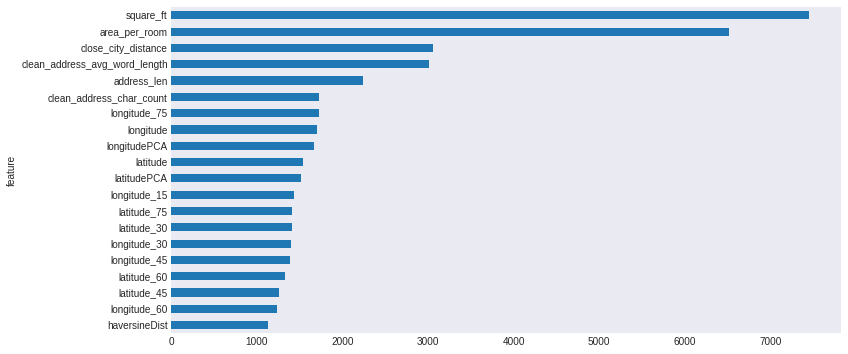

In [ ]:
lgb = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        random_state = 42
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(lgb, fit_params, trainPro, testPro, cat_num_cols)

In [ ]:
# lgb_preds_t = np.expm1(lgb_preds)
# download_preds(lgb_preds_t, file_name = 's30_lgb_log.csv')   

!mv s30_lgb_log.csv '/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files'

In [ ]:
cb = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(cb, fit_params, trainPro, testPro, cat_num_cols)

In [ ]:
# cb_preds_t = np.expm1(cb_preds) 
# download_preds(cb_preds_t, file_name = 's15_cb.csv')  
!mv s15_cb.csv '/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files'

In [ ]:
xgb = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(xgb, fit_params, trainPro, testPro, cat_num_cols)

In [ ]:
xgb_preds_t = np.expm1(xgb_preds)
# download_preds(xgb_preds_t, file_name = 's21_xgb_nlp.csv')   

# !mv s21_xgb_nlp.csv '/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files'

# Blend Models

In [ ]:
def blend_models_predict():
   return (
       (0.6 * lgb_preds_t) + 
           (0.4 * xgb_preds_t) 
          #  (0.2 * cb_preds_t)
          )

In [ ]:
blend = blend_models_predict()

In [ ]:
# download_preds(blend, file_name = 's24_blend.csv')   

!mv s24_blend.csv '/content/MyDrive/My Drive/Data Science/Machine Hack/Housing Price Prediction 2020/Submission Files'